In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

# %config InlineBackend.figure_formats =['svg']
# %matplotlib inline

## Load and cut all captcha into characters

In [2]:
CHAR_SET = ['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'M', 'N', 'P',
            'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
SEED = 1

captcha_path = Path('./captcha')
train_path = captcha_path / 'train'
test_path = captcha_path / 'test'

chars = []
for img_file in tqdm(sorted(train_path.glob('*.png'))):
    img = Image.open(img_file).convert('L')
    img = np.array(img)[:, 1:-2]
    char = np.split(img, 4, axis=1)
    chars += char
chars = np.stack(chars)
chars_flatten = chars.reshape(chars.shape[0], -1)

  0%|          | 0/500 [00:00<?, ?it/s]

## Feature extraction using PCA

In [3]:
pca = PCA(n_components=40, random_state=SEED)
chars_feature = pca.fit_transform(chars_flatten)

## Label 200 characters manually

In [4]:
# y = []
# for i in range(200):
#     plt.imshow(chars[i], cmap='gray')
#     plt.title(i)
#     plt.show()
#     while True:
#         l = input()
#         if (l.isupper() or l.isnumeric()) and len(l)==1:
#             break
#     y.append(l)


y = ['D', 'B', 'T', 'M', 'Q', 'J', 'R', '7', '5', 'V', 'X', 'J', '5', 'J', '3', '3', 'T', 'H', '4', 'M', 'H', 'X', 'J',
     'Q', 'J', '4', 'H', 'U', '5', 'G', 'U', 'N', 'Y', 'K', 'K', 'C', 'G', 'Q', '6', '7', 'T', 'A', 'E', '4', 'C', 'M',
     'Q', 'B', 'Q', 'X', 'U', '5', 'Q', 'G', 'R', 'Y', 'R', 'D', 'D', 'P', '4', 'F', 'D', 'C', 'D', 'C', 'T', 'F', '7',
     'U', 'K', 'Z', 'C', 'N', 'W', 'C', 'S', 'S', 'X', '2', 'N', 'R', 'G', 'Z', 'Z', '2', 'M', 'A', 'X', 'X', 'E', 'F',
     'B', 'P', 'K', 'X', 'W', 'Q', 'T', 'K', 'W', 'X', 'Z', 'X', 'X', 'Y', 'G', 'B', 'P', 'M', 'V', '4', 'W', 'J', 'H',
     'S', 'B', 'X', 'D', 'A', 'W', 'A', '7', 'H', 'T', '3', '4', 'R', 'C', 'Q', 'R', 'F', 'H', 'F', 'Q', 'V', 'D', 'H',
     'C', 'P', 'G', 'J', 'T', 'N', 'T', '9', 'K', 'B', '7', '3', 'E', 'N', 'D', 'A', '4', 'G', 'E', 'T', 'V', 'W', 'H',
     'M', 'Y', '8', 'W', 'G', '6', 'W', 'H', '8', 'V', 'N', 'W', 'H', 'X', '9', 'D', 'P', 'B', 'A', 'U', 'N', 'U', 'A',
     'Z', 'K', 'Z', 'W', 'Z', 'V', '7', 'X', 'K', 'J', 'N', 'B', 'Z', 'U', 'N', 'B']

## Fit the svm classifier

In [5]:
from sklearn.svm import SVC

svm = SVC(random_state=SEED)
svm.fit(chars_feature[:len(y)], y)
predict = svm.predict(chars_feature)

## Characters classification demo

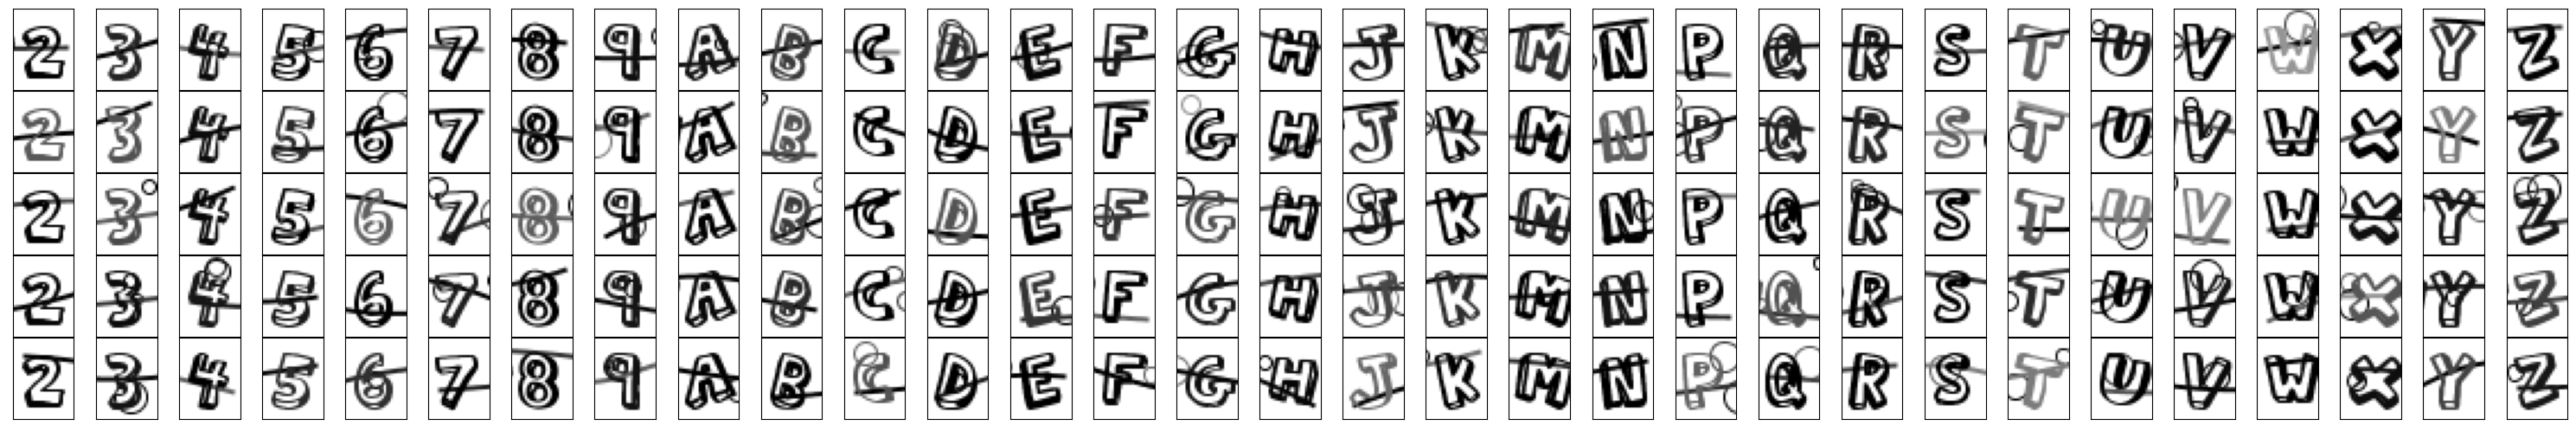

In [6]:
classified = [chars[predict == i] for i in CHAR_SET]

fig, axes = plt.subplots(5, len(CHAR_SET), figsize=(31, 5), dpi=100, subplot_kw={'xticks': [], 'yticks': []})
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.03, hspace=.01)
for idx in range(len(classified)):
    for i in range(5):
        axes[i, idx].imshow(classified[idx][i], cmap='gray')
plt.show()

## Captcha classification demo

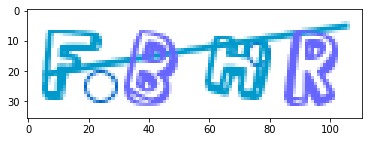

'FBHR'

In [7]:
import pickle


def predictor(img, clf=()):
    pca, svm = clf

    img = img.convert('L')
    img = np.array(img)[:, 1:-2]
    chars = np.split(img, 4, axis=1)
    chars = np.stack([char.flatten() for char in chars])

    feature = pca.transform(chars)
    predict = svm.predict(feature)
    return ''.join(predict)


test_img = Image.open(test_path / 'FBHR.png')
clf = (pca, svm)
pickle.dump(clf, open('captcha_clf.pkl', 'wb'))
plt.imshow(np.array(test_img))
plt.show()
predictor(test_img, clf)

## Calculate captcha classification accuracy

  0%|          | 0/1000 [00:00<?, ?it/s]

Acc: 0.989


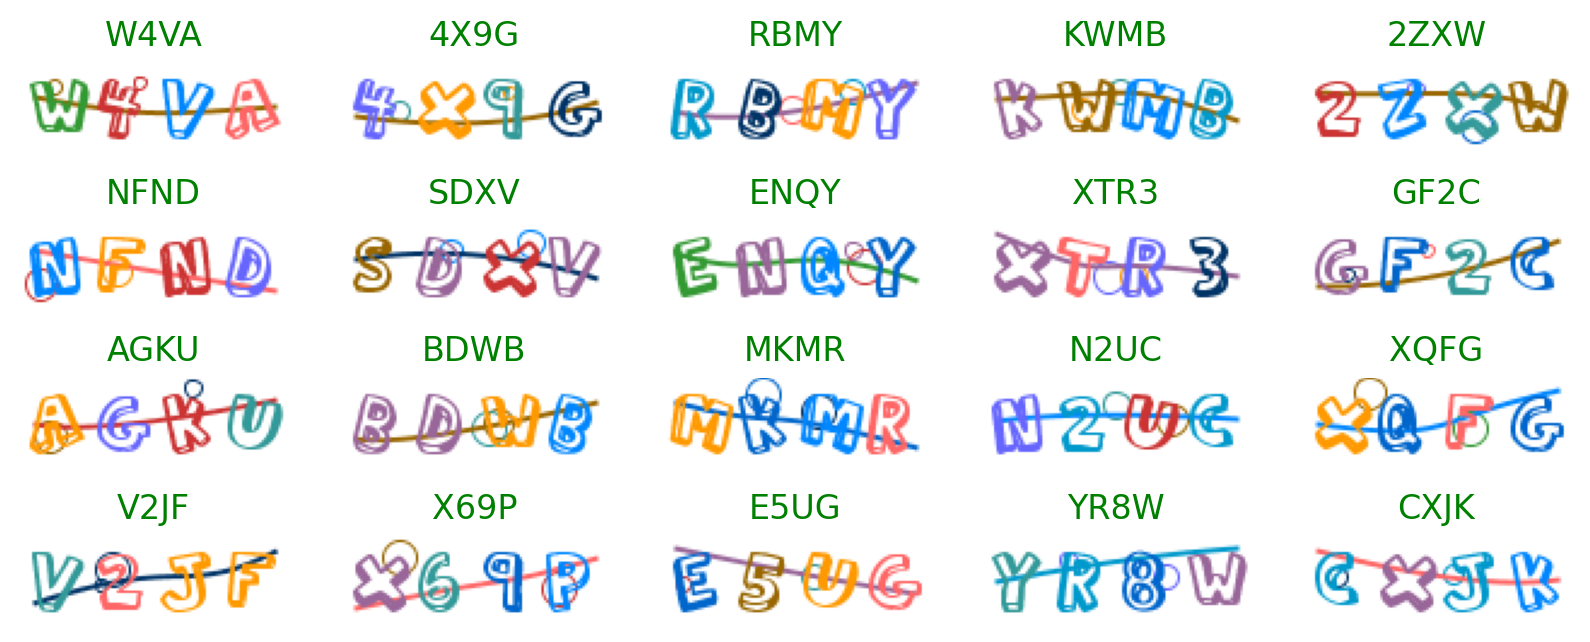

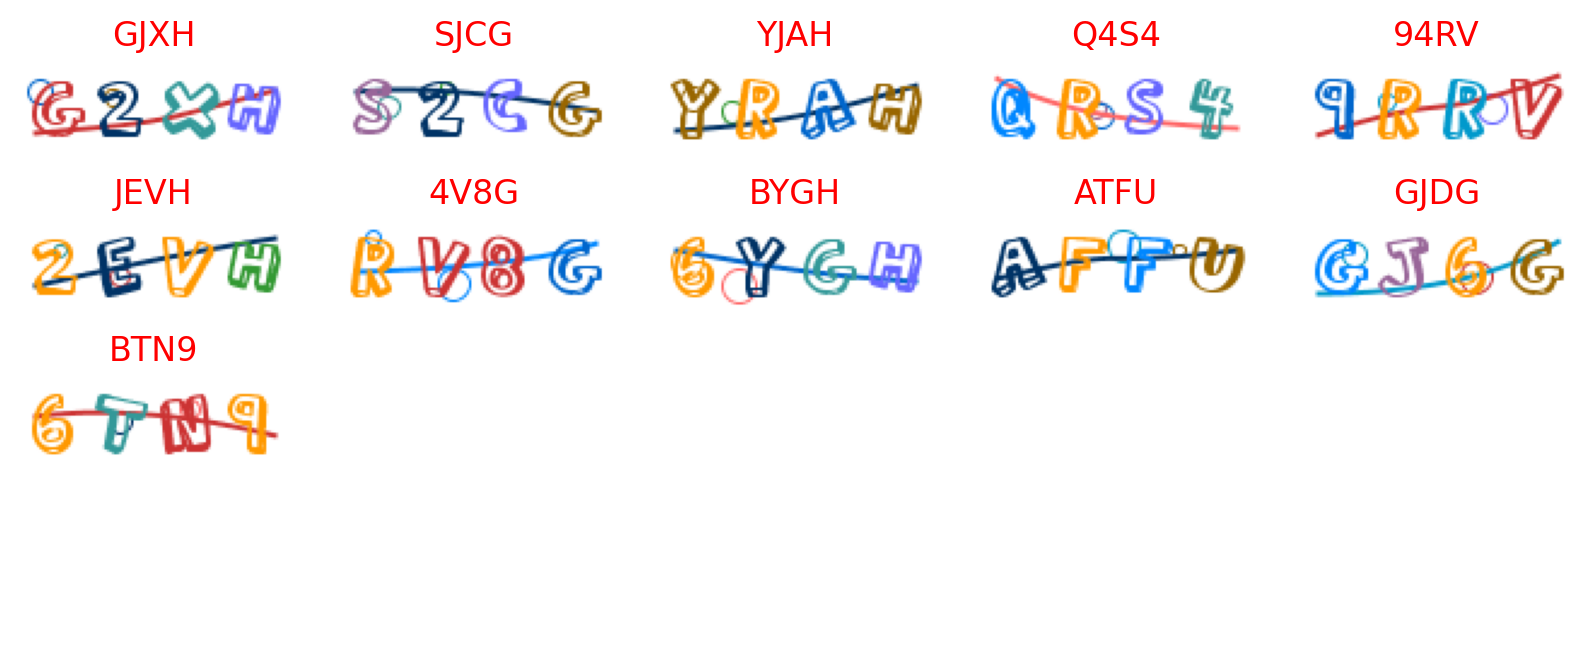

In [8]:
from random import shuffle

fig_c, axes_c = plt.subplots(4, 5, figsize=(10, 4), dpi=200, subplot_kw={'xticks': [], 'yticks': []})
fig_e, axes_e = plt.subplots(4, 5, figsize=(10, 4), dpi=200, subplot_kw={'xticks': [], 'yticks': []})
[ax.axis('off') for ax in axes_c.flatten()]
[ax.axis('off') for ax in axes_e.flatten()]

clf = (pca, svm)
correct, error = 0, 0

test_dataset = list(test_path.glob('*.png'))
shuffle(test_dataset)

for img_file in tqdm(test_dataset):
    img = Image.open(img_file)
    label = img_file.stem

    predict = predictor(img, clf)

    if predict == label:
        if correct < 20:
            axes_c.flatten()[correct].imshow(np.array(img))
            axes_c.flatten()[correct].set_title(predict, color='g')
        correct += 1
    else:
        if error < 20:
            axes_e.flatten()[error].imshow(np.array(img))
            axes_e.flatten()[error].set_title(predict, color='r')
        error += 1
print(f'Acc: {correct / (correct + error)}')

## Display Confusion Matrix

  0%|          | 0/1000 [00:00<?, ?it/s]

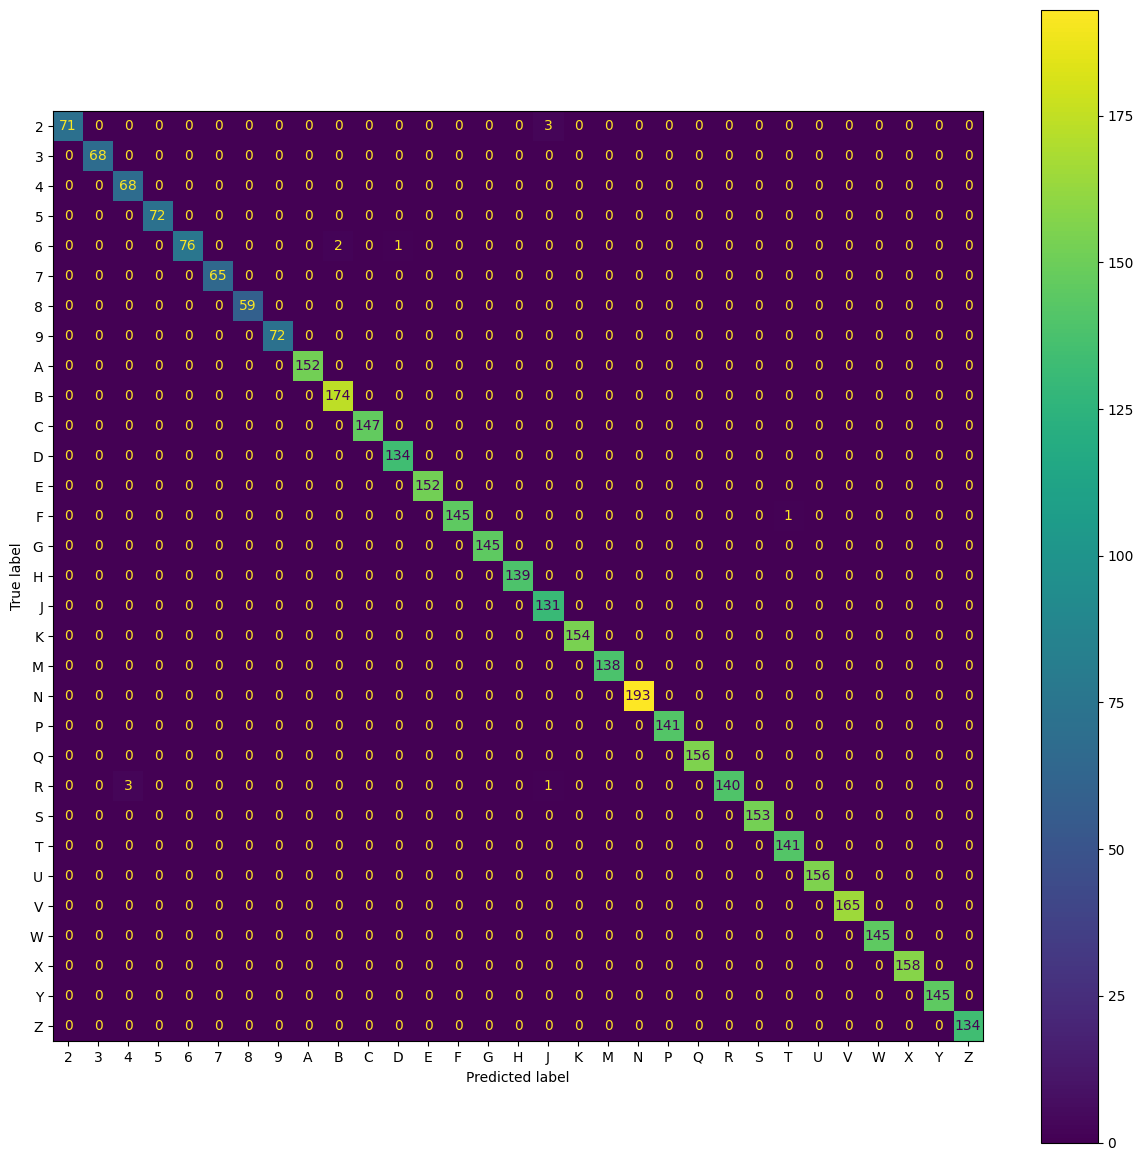

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

x_test, y_test = [], []
for img_file in tqdm(sorted(test_path.glob('*.png'))):
    img = Image.open(img_file).convert('L')
    img = np.array(img)[:, 1:-2]
    char = np.split(img, 4, axis=1)
    x_test += char
    y_test += list(img_file.stem)
x_test, y_test = np.stack(x_test), np.stack(y_test)
x_test = x_test.reshape(x_test.shape[0], -1)

x_pca = pca.transform(x_test)
y_predict = svm.predict(x_pca)
confusion_mat = confusion_matrix(y_test, y_predict)

fig, ax = plt.subplots(figsize=(15, 15), dpi=100)
disp = ConfusionMatrixDisplay(confusion_mat, display_labels=CHAR_SET)
disp.plot(ax=ax)
plt.show()

## Calculate accuracy of each class

In [10]:
overall_acc = np.diag(confusion_mat).sum() / np.sum(confusion_mat)
class_acc = np.diag(confusion_mat) / np.sum(confusion_mat, axis=1)
print('Char:', '     '.join(CHAR_SET))
print('Acc: ', ' '.join([f'{acc:.3f}' for acc in class_acc]))
print(f'Overall Acc: {overall_acc:.4f}')
print(f'Average Acc: {class_acc.mean():.4f}')

Char: 2     3     4     5     6     7     8     9     A     B     C     D     E     F     G     H     J     K     M     N     P     Q     R     S     T     U     V     W     X     Y     Z
Acc:  0.959 1.000 1.000 1.000 0.962 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 0.993 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 0.972 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000
Overall Acc: 0.9972
Average Acc: 0.9964


## Visualize features extracted by PCA

C:\Users\ZCH\anaconda3\envs\DataMining\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ZCH\anaconda3\envs\DataMining\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


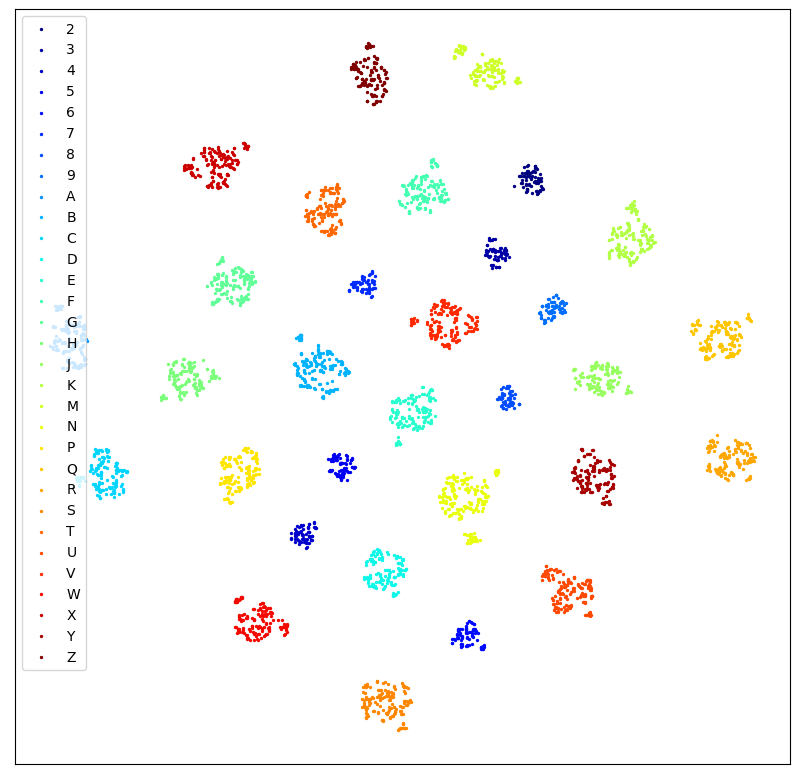

In [11]:
from sklearn.manifold import TSNE

x_tsne = TSNE(n_components=2, random_state=SEED).fit_transform(x_pca)

fig, ax = plt.subplots(figsize=(10, 10), dpi=100, subplot_kw={'xticks': [], 'yticks': []})
cmap = plt.get_cmap('jet', len(CHAR_SET))
for idx, char in enumerate(CHAR_SET):
    x = x_tsne[y_test == char]
    ax.scatter(x[:, 0], x[:, 1], s=2, color=cmap(idx), label=char)
ax.legend()
plt.show()